Next I'm going to use Spectral Clustering to cluster the Levenshtein distances. I can choose the number of clusters and since I know there are 3 datasets I will choose 3. Let's see if we can get some overlap between clusters using this method. 

In [1]:
import pandas as pd
import numpy as np
from sklearn.cluster import AffinityPropagation as Aff
import numpy as np
import distance
from sklearn import metrics
import matplotlib.pyplot as plt

%matplotlib inline
import Levenshtein as lev
import editdistance as ed
import seaborn as sns

First I'll import and clean the test and train data.

In [194]:
#import train data
train=pd.read_csv('traindf')
train.shape

,Unnamed: 0,abstract,match,med,symbols,blurb8,tokens,lemmas,lemmastr
0,0,NaN,0.0,0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ...","TP53 is tumor protein p53 (human),also BCC7, ...","[' ', 'tp53', 'tumor', 'protein', '(', 'human)...",",tp53,tumor,protein,(,human),also,bcc7,,,lfs1..."
1,1,NaN,0.0,0,EGFR,EGFR is epidermal growth factor receptor (hum...,EGFR is epidermal growth factor receptor (hum...,"[' ', 'egfr', 'epidermal', 'growth', 'factor',...",",egfr,epidermal,growth,factor,receptor,(,huma..."
2,2,NaN,0.0,0,TNF,"TNF is tumor necrosis factor (human),also DIF...","TNF is tumor necrosis factor (human),also DIF...","[' ', 'tnf', 'tumor', 'necrosis', 'factor', '(...",",tnf,tumor,necrosis,factor,(,human),also,dif,..."
3,3,NaN,0.0,0,APOE,"APOE is apolipoprotein E (human),also AD2, AP...","APOE is apolipoprotein E (human),also AD2, AP...","[' ', 'apoe', 'apolipoprotein', 'e', '(', 'hum...",",apoe,apolipoprotein,e,(,human),also,ad2,,,ap..."
4,4,NaN,0.0,0,VEGFA,VEGFA is vascular endothelial growth factor A...,VEGFA is vascular endothelial growth factor A...,"[' ', 'vegfa', 'vascular', 'endothelial', 'gro...",",vegfa,vascular,endothelial,growth,factor,a,(..."


In [119]:
#prepare categories for modeling
train['abstracts'] = train['abstract'].fillna(0)
train['meds']=train['med'].fillna(0) 

In [120]:
train['abstracts2'] =  train['abstracts'].apply(lambda x: int(x)*'k')
train['meds2'] =  train['meds'].apply(lambda x: int(x)*'m')
train['sets'] = train['abstracts2']+train['meds2']
train['sets2'] = train['sets'].replace('','g')
train['sets2'].value_counts()
train = train.drop(columns=['abstract','med','sets'])
train.head()

,Unnamed: 0,match,symbols,blurb8,tokens,lemmas,lemmastr,abstracts,meds,abstracts2,meds2,sets2
0,0,0.0,TP53,"TP53 is tumor protein p53 (human),also BCC7, ...","TP53 is tumor protein p53 (human),also BCC7, ...","[' ', 'tp53', 'tumor', 'protein', '(', 'human)...",",tp53,tumor,protein,(,human),also,bcc7,,,lfs1...",0.0,0,,,g
1,1,0.0,EGFR,EGFR is epidermal growth factor receptor (hum...,EGFR is epidermal growth factor receptor (hum...,"[' ', 'egfr', 'epidermal', 'growth', 'factor',...",",egfr,epidermal,growth,factor,receptor,(,huma...",0.0,0,,,g
2,2,0.0,TNF,"TNF is tumor necrosis factor (human),also DIF...","TNF is tumor necrosis factor (human),also DIF...","[' ', 'tnf', 'tumor', 'necrosis', 'factor', '(...",",tnf,tumor,necrosis,factor,(,human),also,dif,...",0.0,0,,,g
3,3,0.0,APOE,"APOE is apolipoprotein E (human),also AD2, AP...","APOE is apolipoprotein E (human),also AD2, AP...","[' ', 'apoe', 'apolipoprotein', 'e', '(', 'hum...",",apoe,apolipoprotein,e,(,human),also,ad2,,,ap...",0.0,0,,,g
4,4,0.0,VEGFA,VEGFA is vascular endothelial growth factor A...,VEGFA is vascular endothelial growth factor A...,"[' ', 'vegfa', 'vascular', 'endothelial', 'gro...",",vegfa,vascular,endothelial,growth,factor,a,(...",0.0,0,,,g


In [121]:
train.shape

(5523, 12)

In [122]:
train = train.dropna(subset = ['blurb8'])
train.shape

(5406, 12)

In [193]:
#import and prepare test data
test=pd.read_csv('test')
test.head()

,Unnamed: 0,abstract,match,med,symbols,blurb8,tokens,lemmas
0,0,NaN,0.0,0,TNF,"TNF is tumor necrosis factor (human),also DIF...","TNF is tumor necrosis factor (human),also DIF...","[' ', 'tnf', 'be', 'tumor', 'necrosis', 'facto..."
1,1,NaN,0.0,0,IL6,"IL6 is interleukin 6 (human),also BSF-2, BSF2...","IL6 is interleukin 6 (human),also BSF-2, BSF2...","[' ', 'il6', 'be', 'interleukin', '6', '(', 'h..."
2,2,NaN,0.0,0,IL10,"IL10 is interleukin 10 (human),also CSIF, GVH...","IL10 is interleukin 10 (human),also CSIF, GVH...","[' ', 'il10', 'be', 'interleukin', '10', '(', ..."
3,3,NaN,0.0,0,MMP9,"MMP9 is matrix metallopeptidase 9 (human),als...","MMP9 is matrix metallopeptidase 9 (human),als...","[' ', 'mmp9', 'be', 'matrix', 'metallopeptidas..."
4,4,NaN,0.0,0,ADIPOQ,"ADIPOQ is adiponectin, C1Q and collagen domai...","ADIPOQ is adiponectin, C1Q and collagen domai...","[' ', 'adipoq', 'be', 'adiponectin', ',', 'c1q..."


Next I'll prepare the Y or target variable for modeling.

In [124]:
#prepare categories for modeling
test['abstracts'] = test['abstract'].fillna(0)
test['meds']=test['med'].fillna(0) 


In [125]:
test['abstracts2'] =  test['abstracts'].apply(lambda x: int(x)*'k')
test['meds2'] =  test['meds'].apply(lambda x: int(x)*'m')
test['sets'] = test['abstracts2']+test['meds2']
test['sets2'] = test['sets'].replace('','g')
test['sets2'].value_counts()
test = test.drop(columns=['abstract','med','sets'])
test.head()

,Unnamed: 0,match,symbols,blurb8,tokens,lemmas,abstracts,meds,abstracts2,meds2,sets2
0,0,0.0,TNF,"TNF is tumor necrosis factor (human),also DIF...","TNF is tumor necrosis factor (human),also DIF...","[' ', 'tnf', 'be', 'tumor', 'necrosis', 'facto...",0.0,0,,,g
1,1,0.0,IL6,"IL6 is interleukin 6 (human),also BSF-2, BSF2...","IL6 is interleukin 6 (human),also BSF-2, BSF2...","[' ', 'il6', 'be', 'interleukin', '6', '(', 'h...",0.0,0,,,g
2,2,0.0,IL10,"IL10 is interleukin 10 (human),also CSIF, GVH...","IL10 is interleukin 10 (human),also CSIF, GVH...","[' ', 'il10', 'be', 'interleukin', '10', '(', ...",0.0,0,,,g
3,3,0.0,MMP9,"MMP9 is matrix metallopeptidase 9 (human),als...","MMP9 is matrix metallopeptidase 9 (human),als...","[' ', 'mmp9', 'be', 'matrix', 'metallopeptidas...",0.0,0,,,g
4,4,0.0,ADIPOQ,"ADIPOQ is adiponectin, C1Q and collagen domai...","ADIPOQ is adiponectin, C1Q and collagen domai...","[' ', 'adipoq', 'be', 'adiponectin', ',', 'c1q...",0.0,0,,,g


In [126]:
test.shape

(2831, 11)

In [127]:
test = test.dropna(subset = ['blurb8'])
test.shape

(2801, 11)

In [128]:
# prepare for Levenshtein distances
words = np.asarray(train['lemmastr'].astype(str))
words.shape

(5406,)

In [129]:
#import time
#start = time.time()
#words = words
#lev_sim = -1*np.array([[ed.eval(w1,w2) for w1 in words] for w2 in words])
#end = time.time()
#print(end - start)


In [130]:
#lev_sim.shape

(5406, 5406)

In [131]:
#lev_simtrdf = pd.DataFrame(lev_sim)

In [132]:
#lev_simtrdf.to_csv('levtrain')

Now I'll import the Levenshtein distances.

In [133]:
#import Levenshtein distances
levtrain = pd.read_csv('levtrain')
levtrain.shape

(5406, 5407)

In [134]:
lev_sim2 = np.array(levtrain)
lev_sim2.shape

(5406, 5407)

In [135]:
lev_sim3 = lev_sim2[:,1:]
len(lev_sim3)


5406

In [136]:
np.min(lev_sim3)

-1839

I have to make all the Levenshtein values positive for Spectral Clustering.

In [137]:
#prepare for modeling
newlev = lev_sim3+1839

In [138]:
np.where(newlev<0)

(array([], dtype=int64), array([], dtype=int64))

I don't need to choose exemplar preferences for Spectral Clustering.

In [60]:
#square = len(lev_sim3)

In [61]:
#pref = np.zeros(shape=(square,square))
#pref.shape

In [62]:
#for c,i in enumerate(train['sets2'],0):
    #if i=='k':
        #pref[c][:]=10
        

In [63]:
#pref.shape

I'll run the model with precomputed Levenshtein distances and a target of 3 clusters.

In [140]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters because there are 3 datasets.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters,affinity='precomputed')
sc.fit(newlev)


SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

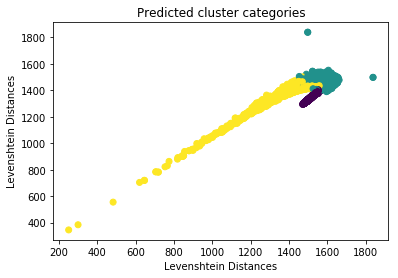

Comparing the assigned categories to the ones in the data. g: genes, k: abstracts, m: medical
col_0     0     1    2
sets2                 
g        26  2297  263
k        33    10  902
m      1871     3    1


In [141]:
#Predicted clusters.
predict=sc.fit_predict(newlev)

#Graph results.
plt.scatter(newlev[:, 0], newlev[:, 1], c=predict)
plt.title('Predicted cluster categories')
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')

plt.show()
print('Comparing the assigned categories to the ones in the data. g: genes, k: abstracts, m: medical')
print(pd.crosstab(train['sets2'],predict))

1.0% of gene strings are classified as medical and 0.16% of medical strings are classified as genes.

In [142]:
#0 is random and 1 is perfect match with ground truth data:
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(train['sets2'], predict))
#0 is random and 1 is perfect match with ground truth data:
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(train['sets2'], predict))
#Best is 1 and worst is -1. Compares size of clusters with distance between cluster:.
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(newlev, predict))

Adjusted Rand Index: 0.839
Adjusted Mutual Information: 0.787
Silhouette Coefficient: 0.537


A crosstab of the original categories and the new clusters show that the gene definitions and medical definitions mostly are not categorized together, and that lots of abstracts are mixed in with both the medical and gene definitions. For our purposes, these results mean success. Analysis using ARI, AMI, and Silhouette Coefficient agree with these results. ARI and AMI show the clusters match fairly well with the original categories, and the Silhouette Coefficient suggests that the clusters are close together.

In [143]:
results = pd.DataFrame(predict)

In [144]:
results['setid']=train['sets2']

In [145]:
results['para']=train['blurb8']

Let's look at some strings within each cluster. 

In [1]:
medslice=pd.DataFrame(results[results[0]==0])

NameError: name 'pd' is not defined

Below are the ones misclassified into the medical cluster.

In [151]:
incorrect= pd.DataFrame(medslice[medslice['setid']=='g'])
incorrect['para']

1384     STAT2 is signal transducer and activator of t...
1400     IGH is immunoglobulin heavy locus (human),als...
1660     DNASE1 is deoxyribonuclease 1 (human),also DN...
2070     NDC80 is NDC80, kinetochore complex component...
2091     FKBP4 is FK506 binding protein 4 (human),also...
2260     NME2 is NME/NM23 nucleoside diphosphate kinas...
3233     sc is scute [Drosophila melanogaster (fruit f...
3238     HNF4A is hepatocyte nuclear factor 4 alpha (h...
3239     Sh is Shaker [Drosophila melanogaster (fruit ...
3263     CXCL10 is C-X-C motif chemokine ligand 10 (hu...
3264    cytochrome c maturation protein CcmFN [Nymphae...
3265    ATPase subunit 6 [Nymphaea colorata],and DDH69...
3266    succinate dehydrogenase subunit 4 [Nymphaea co...
3267    cytochrome c oxidase subunit 3 [Nymphaea color...
3268    cytochrome c biogenesis FC [Nymphaea colorata]...
3269    NADH dehydrogenase subunit 6 [Nymphaea colorat...
3270    apocytochrome b [Nymphaea colorata],and DDH69_...
3271    riboso

Many of the gene definitions classified in the medical cluster mention species called Nymphaea and Drosophila. It seems like this could be fixed by adding more non-human gene abstracts to the model, but more testing needs to be done.

In [164]:
geneslice=pd.DataFrame(results[results[0]==1])
incorrect = pd.DataFrame(geneslice[geneslice['setid']=='m'])
incorrect['para']

3941    CAO  is  conscious, alert, and oriented (no al...
4666        LLE   is  left lower limb (anatomy) extremity
4926    OR  is  operating room (aka operating theatre ...
Name: para, dtype: object

The above medical strings have been miss-classified as gene, possibly because the word spellings are close to those of words used in the gene definitions. 

In [165]:
abstractslice=pd.DataFrame(results[results[0]==2])
abstractslice.iloc[:,2]

7        ERBB2 is erb-b2 receptor tyrosine kinase 2 (h...
11       APP is amyloid beta precursor protein (human)...
12       HIF1A is hypoxia inducible factor 1 subunit a...
23       KRAS is KRAS proto-oncogene, GTPase (human),a...
29       PTEN is phosphatase and tensin homolog (human...
34       HLA-B is major histocompatibility complex, cl...
42       CXCR4 is C-X-C motif chemokine receptor 4 (hu...
46       BRCA2 is BRCA2, DNA repair associated (human)...
54       CCL2 is C-C motif chemokine ligand 2 (human),...
61       PIK3CA is phosphatidylinositol-4,5-bisphospha...
68       CD44 is CD44 molecule (Indian blood group) (h...
69       CYP2D6 is cytochrome P450 family 2 subfamily ...
70       KIT is KIT proto-oncogene receptor tyrosine k...
73       FAS is Fas cell surface death receptor (human...
78       CYP2C19 is cytochrome P450 family 2 subfamily...
84       SPP1 is secreted phosphoprotein 1 (human),als...
99       RET is ret proto-oncogene (human),also CDHF12...
112      CAV1 

Gene definitions classified as abstracts mention proto-oncogenes, which occurs in both abstracts and definitions. 

Now I'll model the test data.

In [166]:
# prepare for Levenshtein distances
wordst = np.asarray(test['lemmas'].astype(str))
wordst.shape


(2801,)

In [167]:
#import time
#start = time.time()
words = wordst
lev_simte = -1*np.array([[ed.eval(w1,w2) for w1 in words] for w2 in words])
#end = time.time()
#print(end - start)

In [168]:
lev_simtest = pd.DataFrame(lev_simte)

In [169]:
lev_simtest.to_csv('levtest')

In [170]:
#import Levenshtein distances
levtest = pd.read_csv('levtest')
levtest.shape

(2801, 2802)

In [171]:
lev_simt2 = np.array(levtest)
lev_simt2.shape

lev_simt3 = lev_simt2[:,1:]
len(lev_simt3)

np.min(lev_simt3)

-2494

In [172]:
#prepare for modeling
newlevt = lev_simt3+2494


np.where(newlev<0)

(array([], dtype=int64), array([], dtype=int64))

In [173]:
newlevt.shape

(2801, 2801)

In [174]:
from sklearn.cluster import SpectralClustering

# We know we're looking for three clusters.
n_clusters=3

# Declare and fit the model.
sc = SpectralClustering(n_clusters=n_clusters,affinity='precomputed')
sc.fit(newlevt)

SpectralClustering(affinity='precomputed', assign_labels='kmeans', coef0=1,
          degree=3, eigen_solver=None, eigen_tol=0.0, gamma=1.0,
          kernel_params=None, n_clusters=3, n_init=10, n_jobs=1,
          n_neighbors=10, random_state=None)

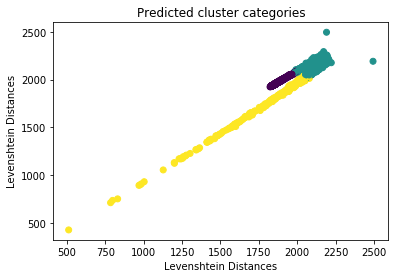

Comparing the assigned categories to the ones in the data. g: genes, k: abstracts, m: medical
col_0     0    1    2
sets2                
g         3  614   78
k         3   46  199
m      1841   17    0


In [175]:
#Predicted clusters.
predictt=sc.fit_predict(newlevt)

#Graph results.
plt.scatter(newlevt[:, 0], newlevt[:, 1], c=predictt)
plt.title('Predicted cluster categories')
plt.xlabel('Levenshtein Distances')
plt.ylabel('Levenshtein Distances')
plt.show()
print('Comparing the assigned categories to the ones in the data. g: genes, k: abstracts, m: medical')
print(pd.crosstab(test['sets2'],predictt))


0.43% of genes were classified as 'medical' and 0.9% of medical strings data were classified as 'gene'.

I've gotten similar results. I'll skip ARI, AMI, and Silhouette Coefficient as they don't seem particularly useful for this application. I'd rather get straight into examining the strings in the clusters.

In [176]:
resultst = pd.DataFrame(predictt)

In [177]:
resultst['setid']=test['sets2']
resultst['para']=test['blurb8']
resultst.head()

,0,setid,para
0,1,g,"TNF is tumor necrosis factor (human),also DIF..."
1,1,g,"IL6 is interleukin 6 (human),also BSF-2, BSF2..."
2,1,g,"IL10 is interleukin 10 (human),also CSIF, GVH..."
3,1,g,"MMP9 is matrix metallopeptidase 9 (human),als..."
4,1,g,"ADIPOQ is adiponectin, C1Q and collagen domai..."


In [178]:
medslicet=pd.DataFrame(resultst[resultst[0]==0])

In [189]:
incorrectt = medslicet[medslicet['setid']=='g']
incorrectt.iloc[:,2].value_counts()

 COL18A1 is collagen type XVIII alpha 1 chain (human),also KNO, KNO1, KS,It is collagen alpha-1(XVIII) chain; antiangiogenic agent; collagen alpha-1(XVIII) chain isoform 1 preproprotein; collagen, type XVIII, alpha 1; endostatin; multi-functional protein MFP,Chromosome: 21; Location: 21q22.3,Annotation: Chromosome 21 NC_000021.9 (45405137..45513720),MIM: 120328    1
 ICAM1 is intercellular adhesion molecule 1 (human),also BB2, CD54, P3.58,It is intercellular adhesion molecule 1; ICAM-1; cell surface glycoprotein P3.58; intercellular adhesion molecule 1 (CD54), human rhinovirus receptor; major group rhinovirus receptor,Chromosome: 19; Location: 19p13.2,Annotation: Chromosome 19 NC_000019.10 (10270841..10286615),MIM: 147840     1
 UCP2 is uncoupling protein 2 (human),also BMIQ4, SLC25A8, UCPH,It is mitochondrial uncoupling protein 2; solute carrier family 25 member 8; uncoupling protein 2 (mitochondrial, proton carrier),Chromosome: 11; Location: 11q13.4,Annotation: Chromosome 11 NC_00001

These gene definitions misclassified as medical mention rhinovirus and collagen, which makes sense.

In [190]:
geneslicet=pd.DataFrame(resultst[resultst[0]==1])

In [191]:
incorrectt = geneslicet[geneslicet['setid']=='m']
incorrectt.iloc[:,2]

1247    C2    is  Axis (anatomy) axis  – second cervic...
1280    CCJA is  clubbing, cyanosis, jaundice and anaemia
1334    CME   is  continuing medical education       C...
1549                    EGF   is  epidermal growth factor
1596              FAP  is  familial adenomatous polyposis
1857                                 Inc   is  incomplete
1900    IVPB   is  Intravenous therapy#Infusion equipm...
2032    MCC  is  Motor Cycle MotorCycle  Collision, Mo...
2060               MIF    is  Müllerian inhibitory factor
2223                                   Oint  is  ointment
2314    PKU  is  phenylketonuria  (PKU card—see Guthri...
2330            PNET  is  primitive neuroectodermal tumor
2374       PTD  is  prior to discharge   preterm delivery
2380                            PTU  is  propylthiouracil
2785                  VSD   is  ventricular septal defect
Name: para, dtype: object

Some of these medical definitions classified as genes have the keywords 'factor' and 'tumor' which occur often in the gene definitions.

In [192]:
abstractslicet=pd.DataFrame(resultst[resultst[0]==2])
abstractslicet.iloc[:,2]


5       AKT1 is AKT serine/threonine kinase 1 (human)...
8       CXCL8 is C-X-C motif chemokine ligand 8 (huma...
9       HLA-B is major histocompatibility complex, cl...
17      CYP2C19 is cytochrome P450 family 2 subfamily...
21      NOD2 is nucleotide binding oligomerization do...
23      CYP1A1 is cytochrome P450 family 1 subfamily ...
28      MUC1 is mucin 1, cell surface associated (hum...
42      HSP90AA1 is heat shock protein 90 alpha famil...
56      POU5F1 is POU class 5 homeobox 1 (human),also...
57      GNAS is GNAS complex locus (human),also AHO, ...
87      FCGR3A is Fc fragment of IgG receptor IIIa (h...
89      PDGFRB is platelet derived growth factor rece...
91      GDF15 is growth differentiation factor 15 (hu...
106     ITGA2 is integrin subunit alpha 2 (human),als...
109     PRKAA1 is protein kinase AMP-activated cataly...
110     SMARCB1 is SWI/SNF related, matrix associated...
114     EIF2AK2 is eukaryotic translation initiation ...
118     SMARCA4 is SWI/SNF rela

This time the gene definitions shown don't mention the word 'oncogene' very much but there is plenty of shared language between the gene definitions and abstracts.

This Spectral Clustering model of Levenshtein similarities between strings does not seem overfit but I think it needs more data to do better. It is easy to see that Spectral Clustering is more suited to our application as an acronym translator than Affinity Propogation. To translate an acronym from a certain field you  first have to match it to a field using the niche technical language of that field. Because Affinity Propogation chooses so many clusters, it is much better at dividing the fields than it is at matching them. Because I'm able to choose 3 clusters for Spectral Clustering, the  results better reflect the similarities shown in the Levenshtein distances between abstracts and the other two categories. If I  want to improve this model, I need to add more gene definitions and more niche medical terms.